## Import Library

In [1]:
!pip install Sastrawi


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import joblib

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from collections import Counter

In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# Pastikan nltk resources sudah diunduh
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

## Feature Extraction

Dataset:

* [SpamSMSIndonesianDataset.csv](https://drive.google.com/uc?export=download&id=1vHGFLJHs_w1Uq6O0IiaHQvvsexSAG2GQ)

In [5]:
df = pd.read_csv('https://drive.google.com/uc?export=download&id=1vHGFLJHs_w1Uq6O0IiaHQvvsexSAG2GQ')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6223 entries, 0 to 6222
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Category        6223 non-null   object
 1   Bahasa          6223 non-null   object
 2   Cleaned_Bahasa  6223 non-null   object
 3   Length          6223 non-null   int64 
 4   Count           6223 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 243.2+ KB


In [6]:
df.Category[df.Cleaned_Bahasa.duplicated()].value_counts()

Category
ham     159
spam     62
Name: count, dtype: int64

In [7]:
df.drop(columns=["Bahasa"], axis=1, inplace=True)
df.dropna(inplace = True)
df.drop_duplicates(keep='first', inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6002 entries, 0 to 6222
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Category        6002 non-null   object
 1   Cleaned_Bahasa  6002 non-null   object
 2   Length          6002 non-null   int64 
 3   Count           6002 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 234.5+ KB


In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df['Cleaned_Bahasa']).toarray()

In [9]:
from sklearn.model_selection import train_test_split

X = tfidf_matrix  # atau BoW/embeddings lainnya
y = df['Category']  # Label kategori, misalnya 'spam' atau 'ham'

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
print(X_train)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## Modeling and Training

In [11]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

model = MultinomialNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

Accuracy: 0.9633638634471274


## Evaluation

In [12]:
print('Classification Report:\n', classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

         ham       0.96      0.99      0.98       983
        spam       0.96      0.83      0.89       218

    accuracy                           0.96      1201
   macro avg       0.96      0.91      0.94      1201
weighted avg       0.96      0.96      0.96      1201



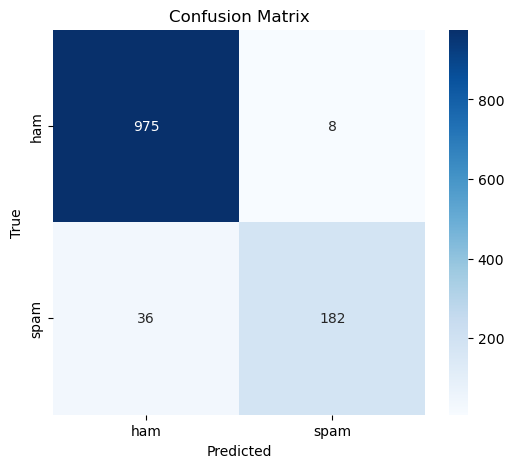

In [13]:
# Menghitung confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualisasi confusion matrix dengan heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['ham', 'spam'], yticklabels=['ham', 'spam'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [14]:
import joblib
%mkdir spam_model

joblib.dump(model, 'spam_model\\spam_model.pkl')
joblib.dump(tfidf_vectorizer, 'spam_model\\tfidf_vectorizer.pkl')

A subdirectory or file spam_model already exists.


['spam_model\\tfidf_vectorizer.pkl']

## Testing Deplyoment

In [15]:
# Load model dan vectorizer
model_load = joblib.load('spam_model\\spam_model.pkl')  # Path ke model yang disimpan
vectorizer_load = joblib.load('spam_model\\tfidf_vectorizer.pkl')  # Path ke vectorizer yang disimpan

In [16]:
def preprocess_text(text):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    # Lowercase
    text = text.lower()

    # Hapus karakter khusus kecuali angka dan spasi
    text = re.sub(r'[^a-z\s]', ' ', text)
    text = re.sub(r'#[A-Za-z0-9]+', ' ', text)
    text = re.sub(r"http\S+", ' ', text)
    text = text.replace('\n', ' ')
    text = text.strip(' ')

    # Tokenisasi
    tokens = word_tokenize(text)

    # Stemming
    tokens = [stemmer.stem(word) for word in tokens]

    # Gabungkan kembali menjadi teks
    text = ' '.join(tokens)

    return text

In [17]:
# Fungsi untuk prediksi input user
def predict_user_input(input_text, model_load, vectorizer_load):
    # Preprocessing
    cleaned_text = preprocess_text(input_text)

    # Transformasi teks menjadi bentuk numerik
    vectorized_text = vectorizer_load.transform([cleaned_text])

    # Prediksi menggunakan model
    prediction = model_load.predict(vectorized_text)

    # Kembalikan hasil prediksi
    return prediction[0]

In [18]:
result = predict_user_input('Hai, perkenalkan aku Farhan', model_load, vectorizer_load)
print(f"Hasil Prediksi: {result}")

Hasil Prediksi: ham


In [19]:
data_dummy_spam = [
        "Selamat! Anda telah memenangkan hadiah undian sebesar 10 juta rupiah. Hubungi kami di nomor ini atau kunjungi www.hadiah-anda-gratis.com segera.",
        "Dapatkan diskon eksklusif hingga 80% untuk produk pilihan kami hanya hari ini. Kunjungi www.promohariini.com untuk info lebih lanjut.",
        "Ayo tingkatkan peluang Anda memenangkan hadiah besar dengan mengikuti survei singkat kami. Klik tautan www.kesempatanemas.com sekarang!",
        "Penawaran spesial terbatas! Dapatkan pinjaman hingga 100 juta tanpa jaminan. Kirim informasi Anda melalui SMS ke 123456 untuk pengajuan cepat.",
        "Liburan impian Anda menunggu! Pesan sekarang dan nikmati potongan harga besar dengan hanya sekali klik di www.liburangratis.com.",
        "Peringatan! Akun Anda terdeteksi aktivitas mencurigakan. Segera perbarui informasi dengan klik www.keamananakun.com agar tetap aman.",
        "Mau gadget baru? Ikuti program undian kami dan menangkan smartphone impian Anda! Hubungi kami di nomor ini segera.",
        "Jangan lewatkan promo spesial akhir tahun kami! Gratis ongkos kirim untuk semua pembelian hari ini saja. Pesan sekarang di www.promo-gratis.com.",
        "Tingkatkan kesehatan Anda dengan produk herbal berkualitas. Promo diskon hingga 50% hanya tersedia di www.herbalpilihan.com.",
        "Kami telah memilih Anda sebagai pemenang hadiah eksklusif! Segera isi formulir klaim di www.hadiahkhusus.com sebelum batas waktu habis."
    ]

# Contoh uji prediksi dengan data dummy
for text in data_dummy_spam:
    result = predict_user_input(text, model_load, vectorizer_load)
    print(f"Teks: {text}\nPrediksi: {result}\n")

Teks: Selamat! Anda telah memenangkan hadiah undian sebesar 10 juta rupiah. Hubungi kami di nomor ini atau kunjungi www.hadiah-anda-gratis.com segera.
Prediksi: spam

Teks: Dapatkan diskon eksklusif hingga 80% untuk produk pilihan kami hanya hari ini. Kunjungi www.promohariini.com untuk info lebih lanjut.
Prediksi: spam

Teks: Ayo tingkatkan peluang Anda memenangkan hadiah besar dengan mengikuti survei singkat kami. Klik tautan www.kesempatanemas.com sekarang!
Prediksi: spam

Teks: Penawaran spesial terbatas! Dapatkan pinjaman hingga 100 juta tanpa jaminan. Kirim informasi Anda melalui SMS ke 123456 untuk pengajuan cepat.
Prediksi: ham

Teks: Liburan impian Anda menunggu! Pesan sekarang dan nikmati potongan harga besar dengan hanya sekali klik di www.liburangratis.com.
Prediksi: ham

Teks: Peringatan! Akun Anda terdeteksi aktivitas mencurigakan. Segera perbarui informasi dengan klik www.keamananakun.com agar tetap aman.
Prediksi: ham

Teks: Mau gadget baru? Ikuti program undian kami da

## SMOTE

In [20]:
from imblearn.over_sampling import SMOTE

# Convert sparse matrix to dense
X_train_dense = X_train

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_dense, y_train)

In [21]:
print("Sebelum SMOTE:", Counter(y_train))
print("Setelah SMOTE:", Counter(y_train_resampled))

Sebelum SMOTE: Counter({'ham': 3869, 'spam': 932})
Setelah SMOTE: Counter({'ham': 3869, 'spam': 3869})


In [23]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

model_smote = MultinomialNB()

# Train model
model_smote = MultinomialNB()
model_smote.fit(X_train_resampled, y_train_resampled)

# Predict on test set
y_pred_smote = model_smote.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

Accuracy: 0.9450457951706911


In [25]:
# Evaluate
print('Classification Report SMOTE:\n', classification_report(y_test, y_pred_smote))

Classification Report SMOTE:
               precision    recall  f1-score   support

         ham       0.99      0.95      0.97       983
        spam       0.79      0.94      0.86       218

    accuracy                           0.95      1201
   macro avg       0.89      0.95      0.91      1201
weighted avg       0.95      0.95      0.95      1201



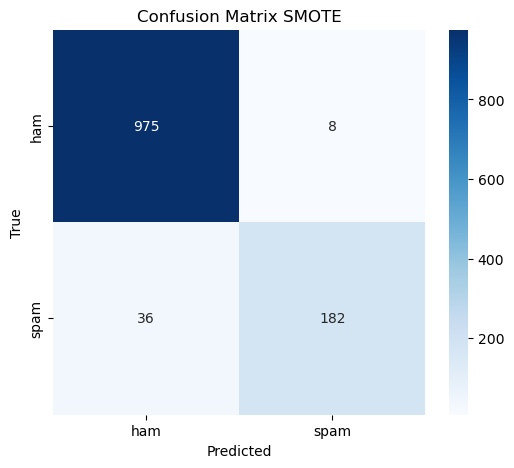

In [27]:
# Menghitung confusion matrix
conf_matrix_smote = confusion_matrix(y_test, y_pred_smote)

# Visualisasi confusion matrix dengan heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['ham', 'spam'], yticklabels=['ham', 'spam'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix SMOTE')
plt.show()

In [33]:
import joblib

joblib.dump(model_smote, 'spam_model\\spam_model_smote.pkl')
joblib.dump(tfidf_vectorizer, 'spam_model\\tfidf_vectorizer_smote.pkl')

['spam_model\\tfidf_vectorizer_smote.pkl']

In [34]:
# Load model dan vectorizer
model_load_smote = joblib.load('spam_model\\spam_model_smote.pkl')  # Path ke model yang disimpan
vectorizer_load_smote = joblib.load('spam_model\\tfidf_vectorizer_smote.pkl')  # Path ke vectorizer yang disimpan

In [35]:
# Fungsi untuk prediksi input user
def predict_user_input_smote(input_text, model, vectorizer_load):
    # Preprocessing
    cleaned_text = preprocess_text(input_text)

    # Transformasi teks menjadi bentuk numerik
    vectorized_text = vectorizer_load.transform([cleaned_text])

    # Prediksi menggunakan model
    prediction = model.predict(vectorized_text)

    # Kembalikan hasil prediksi
    return prediction[0]

In [37]:
data_dummy_spam = [
        "Selamat! Anda telah memenangkan hadiah undian sebesar 10 juta rupiah. Hubungi kami di nomor ini atau kunjungi www.hadiah-anda-gratis.com segera.",
        "Dapatkan diskon eksklusif hingga 80% untuk produk pilihan kami hanya hari ini. Kunjungi www.promohariini.com untuk info lebih lanjut.",
        "Ayo tingkatkan peluang Anda memenangkan hadiah besar dengan mengikuti survei singkat kami. Klik tautan www.kesempatanemas.com sekarang!",
        "Penawaran spesial terbatas! Dapatkan pinjaman hingga 100 juta tanpa jaminan. Kirim informasi Anda melalui SMS ke 123456 untuk pengajuan cepat.",
        "Liburan impian Anda menunggu! Pesan sekarang dan nikmati potongan harga besar dengan hanya sekali klik di www.liburangratis.com.",
        "Peringatan! Akun Anda terdeteksi aktivitas mencurigakan. Segera perbarui informasi dengan klik www.keamananakun.com agar tetap aman.",
        "Mau gadget baru? Ikuti program undian kami dan menangkan smartphone impian Anda! Hubungi kami di nomor ini segera.",
        "Jangan lewatkan promo spesial akhir tahun kami! Gratis ongkos kirim untuk semua pembelian hari ini saja. Pesan sekarang di www.promo-gratis.com.",
        "Tingkatkan kesehatan Anda dengan produk herbal berkualitas. Promo diskon hingga 50% hanya tersedia di www.herbalpilihan.com.",
        "Kami telah memilih Anda sebagai pemenang hadiah eksklusif! Segera isi formulir klaim di www.hadiahkhusus.com sebelum batas waktu habis."
    ]

# Contoh uji prediksi dengan data dummy
for text in data_dummy_spam:
    result = predict_user_input_smote(text, model_load_smote, vectorizer_load_smote)
    print(f"Teks: {text}\nPrediksi: {result}\n")

Teks: Selamat! Anda telah memenangkan hadiah undian sebesar 10 juta rupiah. Hubungi kami di nomor ini atau kunjungi www.hadiah-anda-gratis.com segera.
Prediksi: spam

Teks: Dapatkan diskon eksklusif hingga 80% untuk produk pilihan kami hanya hari ini. Kunjungi www.promohariini.com untuk info lebih lanjut.
Prediksi: spam

Teks: Ayo tingkatkan peluang Anda memenangkan hadiah besar dengan mengikuti survei singkat kami. Klik tautan www.kesempatanemas.com sekarang!
Prediksi: spam

Teks: Penawaran spesial terbatas! Dapatkan pinjaman hingga 100 juta tanpa jaminan. Kirim informasi Anda melalui SMS ke 123456 untuk pengajuan cepat.
Prediksi: spam

Teks: Liburan impian Anda menunggu! Pesan sekarang dan nikmati potongan harga besar dengan hanya sekali klik di www.liburangratis.com.
Prediksi: spam

Teks: Peringatan! Akun Anda terdeteksi aktivitas mencurigakan. Segera perbarui informasi dengan klik www.keamananakun.com agar tetap aman.
Prediksi: spam

Teks: Mau gadget baru? Ikuti program undian kami